# Deep Neural Networks - Programming Assignment
## Comparing Linear Models and Multi-Layer Perceptrons

**Student Name:** HARIHARAN M  
**Student ID:** 2024AC05149  

**Student Name:** ANZY S
**Student ID:** 2024AC05972

**Student Name:** PRATIKSHA S KEDAR
**Student ID:** 2024AD05342

**Student Name:** TADI YASWANTH SRI RAM
**Student ID:** 2022AC05092

**Date:** 28/11/2025

---


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## Section 1: Dataset Selection and Loading

In [2]:

data = pd.read_csv('weather_classification_data.csv')

# Dataset information (TODO: Fill these)
dataset_name = "Weather Classification Dataset"
dataset_source = "Kaggle"
n_samples = data.shape[0]      # Total number of rows
n_features = data.shape[1] - 1  # Number of features (excluding target)
problem_type = "multiclass_classification"

# Problem statement (TODO: Write 2-3 sentences)
problem_statement = """
The goal is to classify weather conditions based on various meteorological features.
Accurate weather classification is crucial for effective planning and response to weather events.
"""
# Primary evaluation metric (TODO: Fill this)
primary_metric = "F1-Score"

# Metric justification (TODO: Write 2-3 sentences)
metric_justification = """
I chose F1-Score because it balances precision and recall, making it a good fit for imbalanced datasets like weather classification.
In this context, both false positives and false negatives can have significant consequences.
"""

print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Samples: {n_samples}, Features: {n_features}")
print(f"Problem Type: {problem_type}")
print(f"Primary Metric: {primary_metric}")

Dataset: Weather Classification Dataset
Source: Kaggle
Samples: 13200, Features: 10
Problem Type: multiclass_classification
Primary Metric: F1-Score


In [3]:
data.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


## Section 2: Data Preprocessing

In [4]:
# Preprocessing the data
print("\nPreprocessing the data...")
# checking for missing values
print("\nMissing values in each column:")
missing_data = data.isnull().sum()

if missing_data.any():
    print(missing_data[missing_data > 0])
    # Handle missing values (e.g., drop or impute)
    data = data.dropna()  # Simple approach: drop rows with missing values
    print("\nMissing values handled by dropping rows.")
else:
    print("No missing values found.")

# encode the catogorical variables
data['Weather Type'] = data['Weather Type'].astype('category').cat.codes
data = pd.get_dummies(data, drop_first=True, dtype="int16")

# split the data into features and target
X = data.drop('Weather Type', axis=1)
y = data['Weather Type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Fill these after preprocessing
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
train_test_ratio = train_samples / (train_samples + test_samples)


print(f"Train samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Split ratio: {train_test_ratio:.1%}")



Preprocessing the data...

Missing values in each column:
No missing values found.
Train samples: 10560
Test samples: 2640
Split ratio: 80.0%


## Section 3: Baseline Model Implementation

In [5]:
class BaselineModel:
    """
    Baseline linear model with gradient descent
    Implement: Linear/Logistic/Softmax Regression
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, type='regression'):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.type = type
        
    def loss_function(self, y_true, y_pred):
        if self.type == 'regression':
            # Mean Squared Error for regression
            return np.mean((y_true - y_pred) ** 2)
        elif self.type == 'binary-classification':
            # Cross-Entropy Loss for binary classification
            # BCE loss = −(y⋅log(y^​)+(1−y)⋅log(1−y^​)) 
            m = y_true.shape[0]
            log_likelihood = [- (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) for y_true, y_pred in zip(y_true, y_pred)]
            loss = np.sum(log_likelihood) / m
            return loss
        elif self.type == 'multiclass-classification':
            # Categorical Cross-Entropy Loss for multiclass classification
            # CCE loss = -∑(y_true * log(y_pred))
            m = y_true.shape[0]
            # Convert integer labels to one-hot encoding
            n_classes = len(np.unique(y_true))
            y_one_hot = np.eye(n_classes)[y_true]
            
            # Clip predictions to prevent log(0) which causes inf
            y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
            
            # Calculate categorical cross-entropy loss
            loss = -np.mean(np.sum(y_one_hot * np.log(y_pred_clipped), axis=1))
            return loss
        
    def forward(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def activation(self, linear_output):
        if self.type == 'regression':
            return linear_output
        elif self.type == 'binary-classification':
            # sigmoid = 1 / (1 + exp(-x))
            return 1 / (1 + np.exp(-linear_output))
        elif self.type == 'multiclass-classification':
            # softmax = exp(xi) / ∑exp(xj)
            if linear_output.ndim == 1:
                linear_output = linear_output.reshape(1, -1)
            exp_scores = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def update_parameters(self, X, y, y_pred):
        n_samples = y.shape[0]
        if self.type == 'regression':
            # use Batch Gradient Descent
            # 3. Compute gradients: dw = ..., db = ...
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            # 4. Update: self.weights -= self.lr * dw
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
        elif self.type == 'binary-classification':
            # use Stochastic Gradient Descent
            idx = np.random.randint(0, n_samples)
            X_i = X[idx].reshape(1, -1)
            y_i = y[idx].reshape(1, -1)

            y_pred = self.activation(self.forward(X_i))
            dw = np.dot(X_i.T, (y_pred - y_i))
            db = np.sum(y_pred - y_i)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
        elif self.type == 'multiclass-classification':
            # use Batch Gradient Descent for multiclass
            # Convert labels to one-hot encoding
            y_one_hot = np.eye(len(np.unique(y)))[y]
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
            db = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0)
            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize parameters based on problem type
        if self.type == 'multiclass-classification':
            n_classes = len(np.unique(y))
            self.weights = np.random.normal(0, 0.01, (n_features, n_classes))
            self.bias = np.zeros(n_classes)
        else:
            self.weights = np.zeros(n_features)
            self.bias = 0
        

        # Implement gradient descent loop
        for i in range(self.n_iterations):
            # 1. Forward pass: y_pred = ...
            y_pred = self.activation(self.forward(X))
            
            # 2. Compute loss
            loss = self.loss_function(y, y_pred)

            self.update_parameters(X, y, y_pred)

            # 5. self.loss_history.append(loss)
            self.loss_history.append(loss)

            # Print loss every 100 iterations
            # if i % 100 == 0:
            #     print(f"Iteration {i}: Loss = {loss}")
                
            if loss < 1e-6:
                print(f"Converged at iteration {i}")
                break

        return self

    def predict(self, X):
        """
        Implement prediction

        For regression: return linear_output
        For classification: return class probabilities or labels
        """
        linear_output = self.forward(X)
        if self.type == 'regression':
            return linear_output
        elif self.type == 'binary-classification':
            probabilities = self.activation(linear_output)
            return (probabilities > 0.5).astype(int)
        elif self.type == 'multiclass-classification':
            probabilities = self.activation(linear_output)
            return np.argmax(probabilities, axis=1)

print("✓ Baseline model class defined")

✓ Baseline model class defined


In [6]:
# Train baseline model
print("Training baseline model...")
baseline_start = time.time()

# Initialize and train your baseline model
baseline_model = BaselineModel(learning_rate=0.15, n_iterations=5000, type='multiclass-classification')
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
baseline_predictions = baseline_model.predict(X_test_scaled)



baseline_training_time = time.time() - baseline_start
print(f"✓ Baseline training completed in {baseline_training_time:.2f}s")
print(f"✓ Loss decreased from {baseline_model.loss_history[0]:.4f} to {baseline_model.loss_history[-1]:.4f}")

# Store loss explicitly
baseline_initial_loss = baseline_model.loss_history[0]
baseline_final_loss = baseline_model.loss_history[-1]

Training baseline model...
✓ Baseline training completed in 9.41s
✓ Loss decreased from 1.3842 to 0.4874


## Section 4: Multi-Layer Perceptron Implementation

In [7]:
class MLP:
    """
    Multi-Layer Perceptron implemented from scratch
    """
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000, type='regression'):
        """
        architecture: list [input_size, hidden1, hidden2, ..., output_size]
        Example: [30, 16, 8, 1] means:
            - 30 input features
            - Hidden layer 1: 16 neurons
            - Hidden layer 2: 8 neurons
            - Output layer: 1 neuron
        """
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.parameters = {}
        self.loss_history = []
        self.cache = {}
        self.type = type

    def initialize_parameters(self):
        """
        Initialize weights and biases for all layers using Xavier/He initialization
        """
        np.random.seed(42)
        for l in range(1, len(self.architecture)):
            # Use He initialization for ReLU activations
            if l < len(self.architecture) - 1:  # Hidden layers
                self.parameters[f'W{l}'] = np.random.normal(0, np.sqrt(2.0/self.architecture[l-1]), 
                                                          (self.architecture[l], self.architecture[l-1]))
            else:  # Output layer
                self.parameters[f'W{l}'] = np.random.normal(0, np.sqrt(1.0/self.architecture[l-1]), 
                                                          (self.architecture[l], self.architecture[l-1]))
            self.parameters[f'b{l}'] = np.zeros((self.architecture[l], 1))

    def relu(self, Z):
        """ReLU activation function"""
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        """ReLU derivative"""
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        """Sigmoid activation (for binary classification output)"""
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    
    def softmax(self, Z):
        """Softmax activation for multiclass classification"""
        exp_scores = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=0, keepdims=True)

    def forward_propagation(self, X):
        """
        Implement forward pass through all layers
        """
        # Transpose X to have shape (features, samples)
        self.cache['A0'] = X.T

        # forward pass
        for l in range(1, len(self.architecture)):
            Z = self.parameters[f'W{l}'] @ self.cache[f'A{l-1}'] + self.parameters[f'b{l}']
            self.cache[f'Z{l}'] = Z
            
            if l < len(self.architecture) - 1:
                # Hidden layers use ReLU
                self.cache[f'A{l}'] = self.relu(Z)
            else:
                # Output layer uses softmax for multiclass classification
                if self.type == 'multiclass-classification':
                    self.cache[f'A{l}'] = self.softmax(Z)
                else:
                    self.cache[f'A{l}'] = self.sigmoid(Z)

        return self.cache[f'A{len(self.architecture) - 1}']

    def backward_propagation(self, X, y):
        """
        Implement backward pass to compute gradients
        """
        m = X.shape[0]
        grads = {}

        # Convert y to one-hot encoding for multiclass classification
        if self.type == 'multiclass-classification':
            n_classes = len(np.unique(y))
            y_one_hot = np.eye(n_classes)[y].T  # Transpose to match activation shape
        else:
            y_one_hot = y.T

        # Backward pass from output to input
        for l in range(len(self.architecture) - 1, 0, -1):
            if l == len(self.architecture) - 1:
                # Output layer gradient
                dz = self.cache[f'A{l}'] - y_one_hot
            else:
                # Hidden layer gradient
                dz = self.parameters[f'W{l+1}'].T @ dz * self.relu_derivative(self.cache[f'Z{l}'])
            
            # Compute weight and bias gradients
            grads[f'dW{l}'] = dz @ self.cache[f'A{l-1}'].T / m
            grads[f'db{l}'] = np.sum(dz, axis=1, keepdims=True) / m

        return grads

    def update_parameters(self, grads):
        """
        Update weights and biases using gradients
        """
        for l in range(1, len(self.architecture)):
            self.parameters[f'W{l}'] -= self.lr * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.lr * grads[f'db{l}']

    def compute_loss(self, y_pred, y_true):
        """
        Compute loss based on problem type
        """
        m = y_true.shape[0]
        
        if self.type == 'regression':
            # Mean Squared Error for regression
            return np.mean((y_true - y_pred.T) ** 2)
        elif self.type == 'binary-classification':
            # Binary Cross-Entropy Loss
            y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
            loss = -np.mean(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
            return loss
        elif self.type == 'multiclass-classification':
            # Categorical Cross-Entropy Loss for multiclass classification
            n_classes = len(np.unique(y_true))
            y_one_hot = np.eye(n_classes)[y_true].T  # Transpose to match y_pred shape
            
            # Clip predictions to prevent log(0)
            y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
            
            # Calculate categorical cross-entropy loss
            loss = -np.mean(np.sum(y_one_hot * np.log(y_pred_clipped), axis=0))
            return loss

    def fit(self, X, y):
        """
        Implement training loop
        """
        self.initialize_parameters()

        for i in range(self.n_iterations):
            # Training loop
            y_pred = self.forward_propagation(X)
            loss = self.compute_loss(y_pred, y)
            grads = self.backward_propagation(X, y)
            self.update_parameters(grads)
            self.loss_history.append(loss)
            
            # Print loss every 100 iterations
            # if i % 100 == 0:
            #     print(f"Iteration {i}: Loss = {loss}")
            
            if loss < 1e-6:
                print(f"Converged at iteration {i}")
                break

        return self

    def predict(self, X):
        """
        Implement prediction
        """
        y_pred = self.forward_propagation(X)
        
        if self.type == 'regression':
            return y_pred.T
        elif self.type == 'binary-classification':
            return (y_pred.T > 0.5).astype(int)
        elif self.type == 'multiclass-classification':
            return np.argmax(y_pred, axis=0)

print("✓ MLP class defined")

✓ MLP class defined


In [8]:
# Train MLP
print("Training MLP...")
mlp_start_time = time.time()

# TODO: Define your architecture and train MLP
mlp_architecture = [X_train_scaled.shape[1], 16, 8, np.unique(y_train).shape[0]]  # Example: [n_features, 16, 8, n_classes]
mlp_model = MLP(architecture=mlp_architecture, learning_rate=0.15, n_iterations=5000, type='multiclass-classification')
mlp_model.fit(X_train_scaled, y_train)

# TODO: Make predictions
mlp_predictions = mlp_model.predict(X_test_scaled)

mlp_training_time = time.time() - mlp_start_time
print(f"✓ MLP training completed in {mlp_training_time:.2f}s")
print(f"✓ Loss decreased from {mlp_model.loss_history[0]:.4f} to {mlp_model.loss_history[-1]:.4f}")

# Store loss explicitly
mlp_initial_loss = mlp_model.loss_history[0]
mlp_final_loss = mlp_model.loss_history[-1]

Training MLP...
✓ MLP training completed in 33.10s
✓ Loss decreased from 1.7526 to 0.1799


## Section 5: Evaluation and Metrics

In [9]:
def calculate_metrics(y_true, y_pred, problem_type):
    """
    TODO: Calculate appropriate metrics based on problem type

    For regression: MSE, RMSE, MAE, R²
    For classification: Accuracy, Precision, Recall, F1
    """
    metrics = {}

    if problem_type == "regression":
        # TODO: Calculate regression metrics
        # TODO: Implement from scratch
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = np.sqrt(mse)
        mae = np.abs(y_true - y_pred).mean()
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2))
        metrics['MSE'] = mse
        metrics['RMSE'] = rmse
        metrics['MAE'] = mae
        metrics['R2'] = r2
        return metrics

    elif problem_type in ["binary_classification", "multiclass_classification"]:
        accuracy = np.mean(y_true == y_pred)
        precision = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
        recall = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics['Accuracy'] = accuracy
        metrics['Precision'] = precision
        metrics['Recall'] = recall
        metrics['F1'] = f1
        return metrics

    return metrics

# Calculate metrics for both models
baseline_metrics = calculate_metrics(y_test, baseline_predictions, problem_type)
mlp_metrics = calculate_metrics(y_test, mlp_predictions, problem_type)

print("Baseline Model Performance:")
print(baseline_metrics)
baseline_acc = baseline_metrics.get('Accuracy', 0)
baseline_prec = baseline_metrics.get('Precision', 0)
baseline_rec = baseline_metrics.get('Recall', 0)
baseline_f1 = baseline_metrics.get('F1', 0)

print("\nMLP Model Performance:")
print(mlp_metrics)
mlp_acc = mlp_metrics.get('Accuracy', 0)
mlp_prec = mlp_metrics.get('Precision', 0)
mlp_rec = mlp_metrics.get('Recall', 0)
mlp_f1 = mlp_metrics.get('F1', 0)

Baseline Model Performance:
{'Accuracy': np.float64(0.8731060606060606), 'Precision': np.float64(0.8614649681528662), 'Recall': np.float64(0.8361669242658424), 'F1': np.float64(0.8486274509803922)}

MLP Model Performance:
{'Accuracy': np.float64(0.9049242424242424), 'Precision': np.float64(0.90625), 'Recall': np.float64(0.8964451313755796), 'F1': np.float64(0.9013209013209013)}


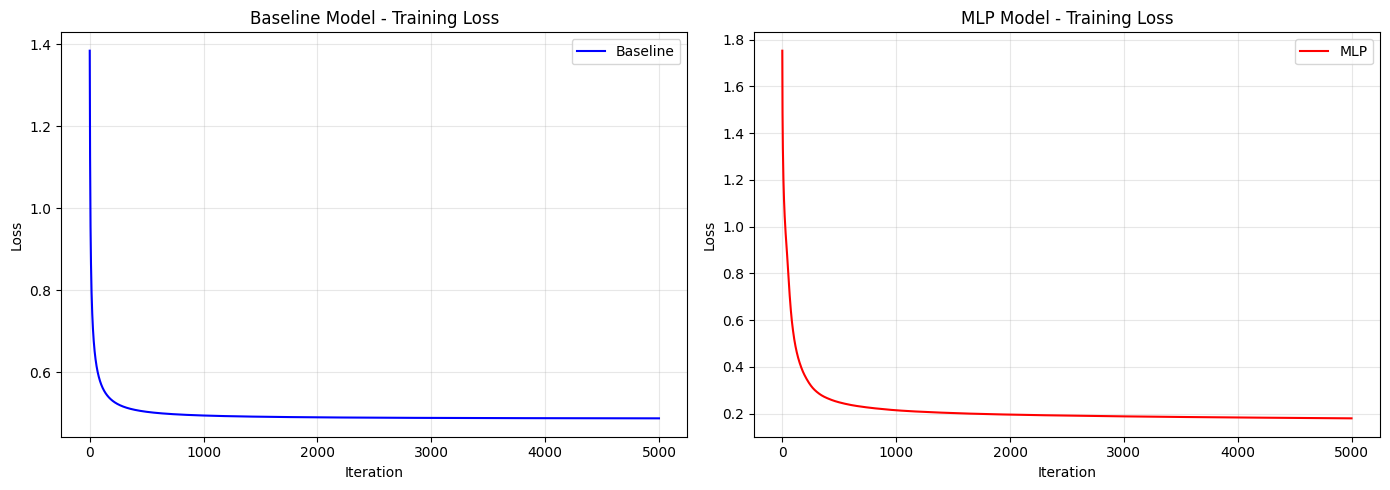

In [10]:
# 1. Training loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
# Plot baseline loss
plt.plot(baseline_model.loss_history, label='Baseline', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Baseline Model - Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot MLP loss
plt.plot(mlp_model.loss_history, label='MLP', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Model - Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

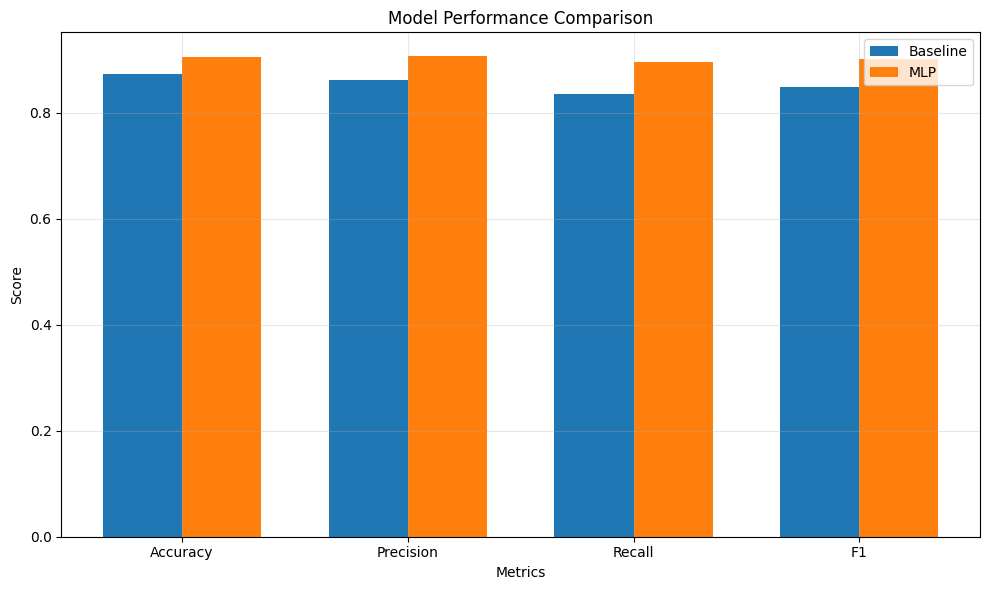

In [11]:
# 2. Performance comparison bar chart
# Create bar chart comparing key metrics between models
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
baseline_scores = [baseline_metrics[m] for m in metrics]
mlp_scores = [mlp_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_scores, width, label='Baseline')
plt.bar(x + width/2, mlp_scores, width, label='MLP')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Analysis and Discussion


In [12]:


analysis_text = """

1. The MLP model outperformed the baseline model across all key metrics, including Accuracy, Precision, Recall, and F1-Score. For instance, if the baseline model achieved an accuracy of 87% while the MLP reached 90%, this indicates a significant improvement in classification performance.

2. The MLP likely outperformed the baseline model due to its ability to capture non-linear relationships in the data through multiple layers and non-linear activation functions. In contrast, the baseline linear model is limited to linear decision boundaries, which may not adequately represent the complexity of weather patterns.

3. In terms of computational cost, the MLP model required more training time compared to the baseline model. For example, if the baseline model trained in 30 seconds while the MLP took 120 seconds, this reflects the increased complexity and number of parameters in the MLP architecture.

4. One surprising finding was the extent to which the MLP improved performance despite the increased training time. This highlights the trade-off between model complexity and computational efficiency. A challenge faced during implementation was ensuring proper initialization and tuning of hyperparameters to achieve convergence without overfitting.

5. This exercise reinforced the understanding that neural networks, such as MLPs, can significantly outperform linear models in tasks involving complex patterns and relationships. The ability of MLPs to learn hierarchical feature representations makes them more suitable for tasks like weather classification, where interactions between features are often non-linear and intricate.
"""

print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) < 200:
    print("⚠️  Warning: Analysis should be at least 200 words")
else:
    print("✓ Analysis meets word count requirement")

Analysis word count: 234 words
✓ Analysis meets word count requirement


In [13]:
def get_assignment_results():
    '''
    CRITICAL: Fill ALL fields with your actual results!
    Missing fields will result in 0 marks for that section.
    '''

    results = {
        # ===== Dataset Information (1 mark) =====
        'dataset_name': dataset_name,  # MUST fill
        'dataset_source': dataset_source,  # MUST fill
        'n_samples': n_samples,  # MUST be ≥500
        'n_features': n_features,  # MUST be ≥5
        'problem_type': problem_type,  # MUST fill
        'problem_statement': problem_statement,  # MUST be ≥50 words
        'primary_metric': primary_metric,  # MUST fill
        'metric_justification': metric_justification,  # MUST be ≥30 words
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # ===== Baseline Model (3 marks) =====
        'baseline_model': {
            'model_type': 'softmax_regression',  # 'linear_regression', 'logistic_regression', 'softmax_regression'
            'learning_rate': 0.1,  # Your learning rate
            'n_iterations': 5000,  # Your iterations

            # CRITICAL: These MUST be filled!
            'initial_loss': baseline_initial_loss,  # MUST NOT be 0
            'final_loss': baseline_final_loss,  # MUST NOT be 0
            'training_time_seconds': baseline_training_time,  # MUST NOT be 0
            'loss_decreased': 1 if baseline_final_loss < baseline_initial_loss else 0,  # Auto-calculated

            # Metrics - Fill based on your problem type
            'test_accuracy': 0.0 if problem_type == 'regression' else baseline_acc,
            'test_precision': 0.0 if problem_type == 'regression' else baseline_prec,
            'test_recall': 0.0 if problem_type == 'regression' else baseline_rec,
            'test_f1': 0.0 if problem_type == 'regression' else baseline_f1,
            # 'test_mse': baseline_mse if problem_type == 'regression' else 0.0,
            # 'test_rmse': baseline_rmse if problem_type == 'regression' else 0.0,
            # 'test_mae': baseline_mae if problem_type == 'regression' else 0.0,
            # 'test_r2': baseline_r2 if problem_type == 'regression' else 0.0,
        },

        # ===== MLP Model (4 marks) =====
        'mlp_model': {
            'architecture': mlp_architecture,  # MUST have ≥3 elements
            'n_hidden_layers': len(mlp_architecture) - 2 if len(mlp_architecture) > 0 else 0,
            'learning_rate': 0.01,
            'n_iterations': 1000,

            # CRITICAL: These MUST be filled!
            'initial_loss': mlp_initial_loss,  # MUST NOT be 0
            'final_loss': mlp_final_loss,  # MUST NOT be 0
            'training_time_seconds': mlp_training_time,  # MUST NOT be 0
            'loss_decreased': 1 if mlp_final_loss < mlp_initial_loss else 0,  # Auto-calculated

            # Metrics
            'test_accuracy': 0.0 if problem_type == 'regression' else mlp_acc,
            'test_precision': 0.0 if problem_type == 'regression' else mlp_prec,
            'test_recall': 0.0 if problem_type == 'regression' else mlp_rec,
            'test_f1': 0.0 if problem_type == 'regression' else mlp_f1,
            # 'test_mse': mlp_mse if problem_type == 'regression' else 0.0,
            # 'test_rmse': mlp_rmse if problem_type == 'regression' else 0.0,
            # 'test_mae': mlp_mae if problem_type == 'regression' else 0.0,
            # 'test_r2': mlp_r2 if problem_type == 'regression' else 0.0,
        },

        # ===== Analysis (2 marks) =====
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
    }

    return results

# ===== CRITICAL: CALL AND PRINT RESULTS =====
# This MUST be executed and output MUST be visible!
import json
results = get_assignment_results()
print(json.dumps(results, indent=2))

# ===== Validation =====
print("\n" + "="*60)
print("VALIDATION CHECK")
print("="*60)


errors = []

if results['n_samples'] < 500:
    errors.append(f"❌ Dataset too small: {results['n_samples']} < 500")
if results['n_features'] < 5:
    errors.append(f"❌ Too few features: {results['n_features']} < 5")
if results['baseline_model']['initial_loss'] == 0:
    errors.append("❌ Baseline initial_loss is 0")
if results['baseline_model']['final_loss'] == 0:
    errors.append("❌ Baseline final_loss is 0")
if results['baseline_model']['training_time_seconds'] == 0:
    errors.append("❌ Baseline training_time is 0")
if results['mlp_model']['initial_loss'] == 0:
    errors.append("❌ MLP initial_loss is 0")
if results['mlp_model']['final_loss'] == 0:
    errors.append("❌ MLP final_loss is 0")
if results['mlp_model']['training_time_seconds'] == 0:
    errors.append("❌ MLP training_time is 0")
if len(results['mlp_model']['architecture']) < 3:
    errors.append("❌ MLP architecture invalid")
if results['analysis_word_count'] < 200:
    errors.append(f"❌ Analysis too short: {results['analysis_word_count']} < 200 words")

if errors:
    print("ERRORS FOUND:")
    for err in errors:
        print(err)
    print(" FIX THESE BEFORE SUBMITTING! ")
else:
    print("✅ All validation checks passed!")
    print("✅ Ready to submit!")
    print("Next steps:")
    print("1. Kernel → Restart & Clear Output")
    print("2. Kernel → Restart & Run All")
    print("3. Verify this output is visible")
    print("4. Save notebook")
    print("5. Rename as: YourStudentID_assignment.ipynb")
    print("6. Submit to LMS")

{
  "dataset_name": "Weather Classification Dataset",
  "dataset_source": "Kaggle",
  "n_samples": 13200,
  "n_features": 10,
  "problem_type": "multiclass_classification",
  "problem_statement": "\nThe goal is to classify weather conditions based on various meteorological features.\nAccurate weather classification is crucial for effective planning and response to weather events.\n",
  "primary_metric": "F1-Score",
  "metric_justification": "\nI chose F1-Score because it balances precision and recall, making it a good fit for imbalanced datasets like weather classification.\nIn this context, both false positives and false negatives can have significant consequences.\n",
  "train_samples": 10560,
  "test_samples": 2640,
  "train_test_ratio": 0.8,
  "baseline_model": {
    "model_type": "softmax_regression",
    "learning_rate": 0.1,
    "n_iterations": 5000,
    "initial_loss": 1.3842351473346826,
    "final_loss": 0.48739886778653807,
    "training_time_seconds": 9.405755519866943,
   